Github link:
https://github.com/kocakale/DataAnalytics/blob/master/DA3_Assignment3.ipynb

# Assignment 3
### Yahya Kocakale
### Apo Duman

### Introduction

Our objective is to construct an effective model for predicting defaulted firms within the 'Manufacture of computer, electronic and optical products' industry for the year 2015. We define default as firms that were operational in 2014 but ceased to exist in 2015, focusing specifically on small or medium enterprises (SMEs) with annual sales ranging from 1000 EUR to 10 million EUR.

Utilizing panel data spanning from 2005 to 2016, we aim to identify key factors contributing to firm default within this industry segment. By leveraging advanced modeling techniques, our goal is to develop a predictive model that enables stakeholders to proactively manage financial risks and enhance industry stability.

Through rigorous data analysis and model building processes, we seek to provide valuable insights into firm default dynamics, facilitating informed decision-making for risk mitigation and sustainable business practices within the specified industry.

We will undertake rigorous data preprocessing, variable selection, and model building processes to construct the best possible predictive model. By employing advanced techniques such as logistic regression, ensemble methods, and cross-validation, we endeavor to achieve high accuracy and reliability in predicting firm defaults, thereby facilitating proactive risk management practices.

### 1. Data preparation

In this part we apply a comprehensive data preprocessing and feature engineering pipeline. It involves handling missing values, creating new features, filtering data, and ensuring data integrity for further analysis.

In [208]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from plotnine import *

warnings.filterwarnings("ignore")


In [209]:
# Import the prewritten helper functions
from py_helper_functions import *


#### 1.1 Import data

In this section, we're loading the data and performing some initial preprocessing steps.

In [210]:
data = pd.read_csv("https://raw.githubusercontent.com/kocakale/hello-world/master/cs_bisnode_panel.csv")

In [211]:
# drop variables with many NAs
data = data.drop(
    columns=["COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages"]
)
data = data.query("year !=2016")



#### 1.2 Label engineering


Here, we're engineering new labels based on the existing data.

In [212]:
# add all missing year and comp_id combinations -
# originally missing combinations will have NAs in all other columns
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)  # only way I could define it as NaN


In [213]:
# generate status_alive; if sales larger than zero and not-NA, then firm is alive
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)

# defaults in one year if there are sales in this year but no sales next year
data["default"] = (
    (data["status_alive"] == 1)
    & (data.groupby("comp_id")["status_alive"].shift(-1) == 0)
).astype(int)


In [214]:
data = data.query("year <= 2014")


In [215]:
data["default"].describe()


count    464120.000000
mean          0.052168
std           0.222365
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: default, dtype: float64

In [216]:
data["sales"].describe()


count    2.431690e+05
mean     4.860328e+05
std      3.869428e+06
min     -1.472559e+07
25%      4.940741e+03
50%      3.017778e+04
75%      1.091630e+05
max      1.110294e+08
Name: sales, dtype: float64

In [217]:
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)  # has to be outside of assin()
data = data.assign(
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),  # NaN remain NaN
    sales_mil=data["sales"] / 1000000,
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)


In [218]:
data["d1_sales_mil_log"] = data["sales_mil_log"] - data.groupby("comp_id")[
    "sales_mil_log"
].shift(1)


In [219]:
# replace w 0 for new firms + add dummy to capture it
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["d1_sales_mil_log"])
)
data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"]
)


In [220]:
data["new"].describe()


count    464120.000000
mean          0.685790
std           0.464201
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: new, dtype: float64

#### 1.3 Sample design

In this section, we're filtering the data based on certain criteria to create a specific sample.

In [221]:
# look at cross section
data = data.query("year>=2012 & year<=2014 & status_alive == 1")
# look at firms below 10m euro revenues and above 1000 euros
data = data.query("sales_mil<=10 & sales_mil>=0.001")


In [222]:
data["default"].describe()


count    64477.000000
mean         0.108861
std          0.311467
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: default, dtype: float64

#### 1.4 Feature engineering

In [223]:
# change some industry category codes
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])


In [224]:
data.groupby("ind2_cat").count()["comp_id"]


ind2_cat
20.0      159
26.0     3167
27.0     1928
28.0     5798
29.0      841
30.0      510
32.0      407
33.0     5855
35.0        1
40.0      636
55.0     6918
56.0    37509
60.0      733
99.0       15
Name: comp_id, dtype: int64

In [225]:
# Firm characteristics
data["age2"] = data["age"] ** 2
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")


In [226]:
###########################################################
# look at more financial variables, create ratios
###########################################################

# assets can't be negative. Change them to 0 and add a flag.
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]


flag_asset_problem
0.0    64420
1.0       34
Name: comp_id, dtype: int64

In [227]:
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])


In the following code blocks, we focus on two key aspects: normalizing profit and loss (P&L) items by sales and normalizing balance sheet (BS) items by total assets. 

In [228]:
# generate total assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()


count    6.445400e+04
mean     2.758985e+05
std      2.094086e+06
min      0.000000e+00
25%      7.470370e+03
50%      2.651667e+04
75%      1.042648e+05
max      3.190691e+08
Name: total_assets_bs, dtype: float64

We define two lists, `pl_names` and `bs_names`, which contain the names of profit/loss and balance sheet variables, respectively. These variables will be used for subsequent calculations.

In [229]:
pl_names = [
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "inc_bef_tax",
    "inventories",
    "material_exp",
    "profit_loss_year",
    "personnel_exp",
]
bs_names = [
    "intang_assets",
    "curr_liab",
    "fixed_assets",
    "liq_assets",
    "curr_assets",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
]


For each profit/loss item in the `pl_names` list, we divide the corresponding column values by the "sales" column. This normalization facilitates comparisons of these financial metrics relative to the company's revenue.

In [230]:
# divide all pl_names elements by sales and create new column for it
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)


Similarly, for each balance sheet item in the `bs_names` list, we divide the corresponding column values by the "total_assets_bs" column. This normalization enables us to analyze the composition of the balance sheet relative to the total assets of the company. In cases where the "total_assets_bs" column contains NaN values, indicating missing or undefined total assets, we set the normalized balance sheet item values to NaN as well. This ensures consistency in the data treatment.

In [231]:
# divide all bs_names elements by total_assets_bs and create new column for it
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )


Additionally, we create flags to identify specific characteristics of financial variables. For instance, we classify variables as "flag_high" if they exceed a certain threshold, "flag_low" if they fall below a threshold, and "flag_error" if they are negative. These flags aid in identifying and categorizing anomalies or outliers in the data.

In [232]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)


In [233]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)


In [234]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)


We perform some additional data processing steps, including CEO age calculation, handling of labor-related variables, and conversion of categorical variables.

In [235]:
########################################################################
# additional
# including some imputation
########################################################################

# CEO age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)


data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)


In [236]:
# number emp, very noisy measure
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"]
)
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)


In [237]:
data["labor_avg"].describe()


count    52055.000000
mean         0.652610
std          1.646404
min          0.083333
25%          0.111111
50%          0.250000
75%          0.555556
max         64.583336
Name: labor_avg, dtype: float64

In [238]:
data["labor_avg_mod"].describe()


count    64477.000000
mean         0.652610
std          1.479328
min          0.083333
25%          0.152778
50%          0.340278
75%          0.652610
max         64.583336
Name: labor_avg_mod, dtype: float64

In [239]:
data = data.drop(["labor_avg"], axis=1)


In [240]:
# create category type variables
data["urban_m"] = data["urban_m"].astype("category")
data["ind2_cat"] = data["ind2_cat"].astype("category")
data["default_f"] = data["default"].astype("category")
data["default_f"] = data["default_f"].cat.rename_categories(["no_default", "default"])


The following code block focuses on analyzing sales-related variables and performing additional data preprocessing steps.

In [241]:
########################################################################
# sales
########################################################################
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2


The code begins by visualizing the relationship between the logarithm of sales (`sales_mil_log`) and the default status (`default`). This is achieved using a scatter plot, overlaid with two smoothed trend lines: one fitted with a linear regression model and another using locally weighted scatterplot smoothing (LOESS).
A similar visualization is created for the growth rate of sales (`d1_sales_mil_log`) against the default status.

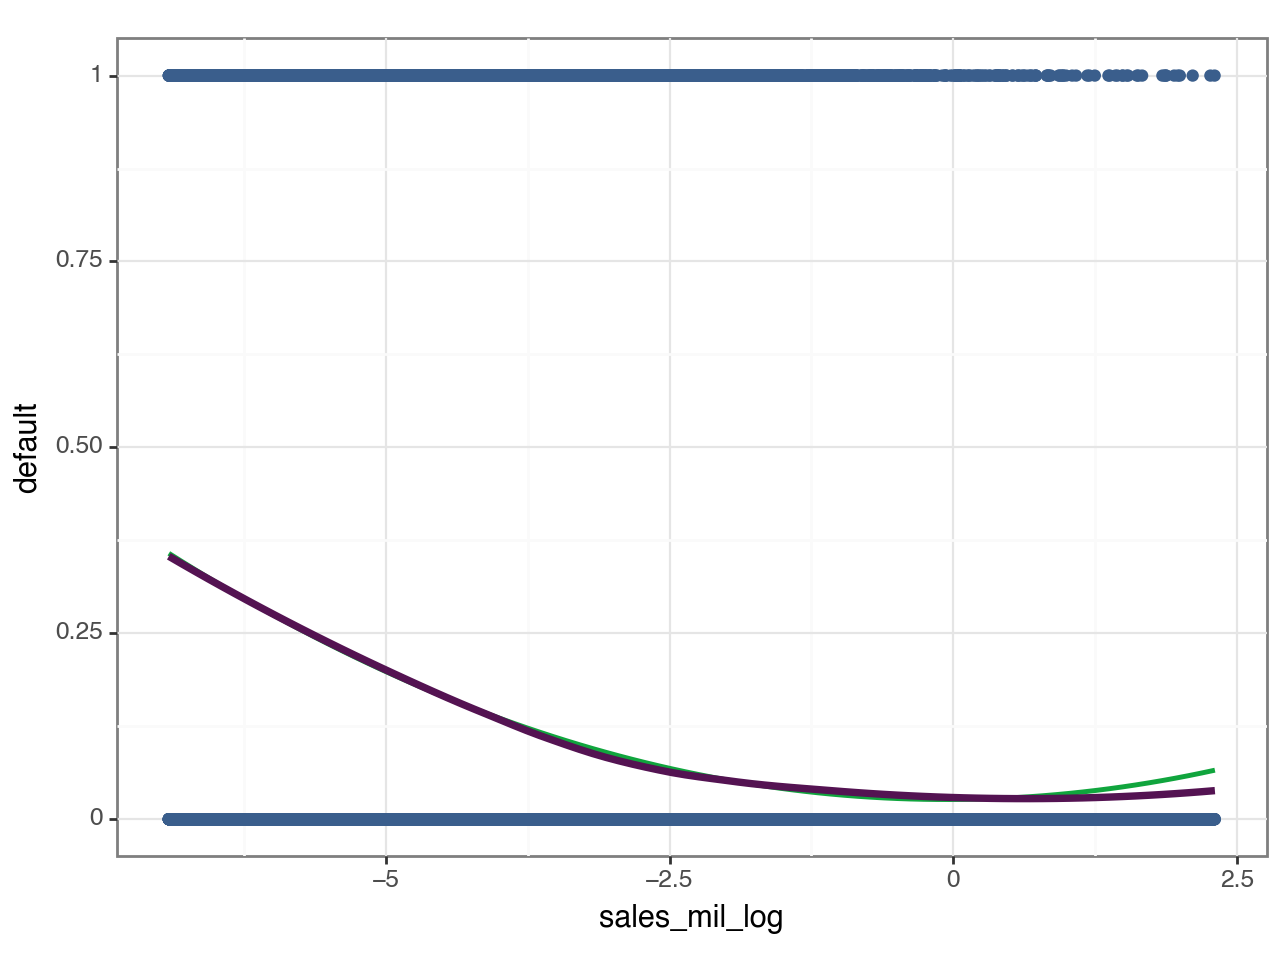

<Figure Size: (640 x 480)>

In [242]:
(
    ggplot(data, aes(x="sales_mil_log", y="default"))
    + geom_point(color=color[0])
    + geom_smooth(method="lm", formula="y ~ x + I(x**2)", color=color[1], se=False)
    + geom_smooth(method="loess", color=color[2], se=False, size=1.5, span=0.9)
    + labs(x="sales_mil_log", y="default")
    + theme_bw()
)


In [243]:
########################################################################
# sales change
########################################################################
# Note: graphs not in book

# lowess
data["d1_sales_mil_log"].describe()


count    64477.000000
mean        -0.043303
std          0.910374
min         -6.907755
25%         -0.127675
50%          0.000000
75%          0.166516
max         11.299683
Name: d1_sales_mil_log, dtype: float64

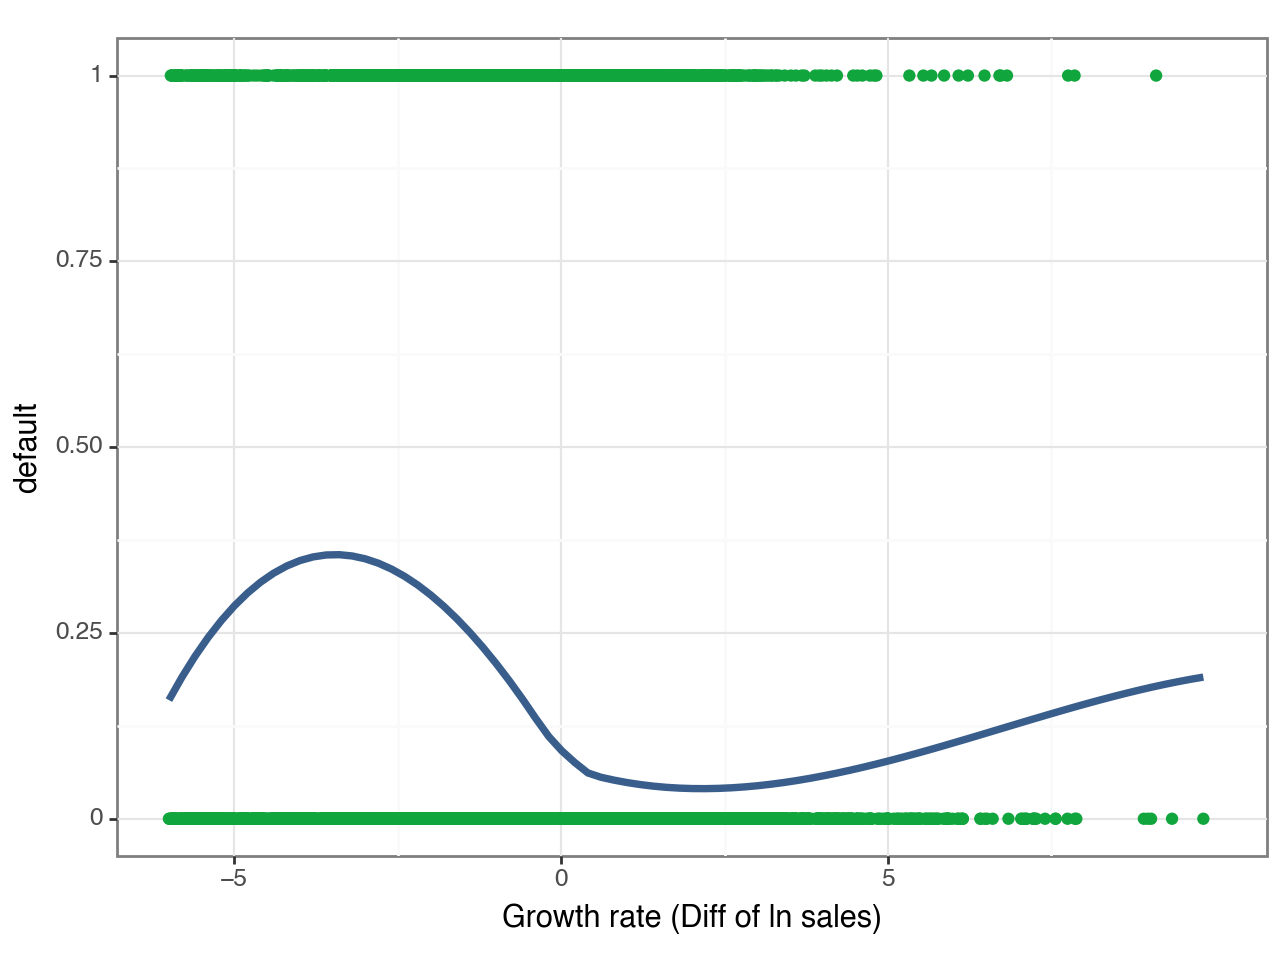

<Figure Size: (640 x 480)>

In [244]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="default"))
    + geom_point(color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="default")
    + scale_x_continuous(limits=(-6, 10), breaks=seq(-5, 10, by=5))
    + theme_bw()
)


Several new variables are generated based on the growth rate of sales (`d1_sales_mil_log`). Flags are created to identify instances where the growth rate exceeds certain thresholds.
Additionally, the growth rate variable is modified to limit extreme values, a process known as "winsorization."

In [245]:
# generate variables ---------------------------------------------------

data["flag_low_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] < -1.5, 1, 0)
data["flag_high_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] > 1.5, 1, 0)
data["d1_sales_mil_log_mod"] = np.where(
    data["d1_sales_mil_log"] < -1.5,
    -1.5,
    np.where(data["d1_sales_mil_log"] > 1.5, 1.5, data["d1_sales_mil_log"]),
)
data["d1_sales_mil_log_mod_sq"] = data["d1_sales_mil_log_mod"] ** 2

In [246]:
data_holdout = data.query("year == 2014 & ind2 == 26")

for col in data_holdout.columns:
    if data_holdout[col].dtype == np.number:
        data_holdout.loc[data_holdout[col].isna(), col] = data_holdout[col].mean()
    else:
        data_holdout.loc[data_holdout[col].isna(), col] = data_holdout[col].mode().iloc[0]

Missing values are dropped for key variables related to the balance sheet, foreign status, and industry.

In [247]:
# no more imputation, drop obs if key vars missing
data = data.dropna(subset=["liq_assets_bs", "foreign", "ind"])

In [248]:
# drop missing
data = data.dropna(subset=["age", "foreign", "material_exp_pl", "m_region_loc"])
data["age"].describe()


count    57430.000000
mean         9.143897
std          7.170436
min          0.000000
25%          3.000000
50%          7.000000
75%         15.000000
max         63.000000
Name: age, dtype: float64

Unused factor levels in categorical variables are removed to streamline the dataset.

In [249]:
# drop unused factor levels
for col in data.select_dtypes(include=["category"]).columns:
    data[col] = data[col].cat.remove_unused_categories()
    
for col in data_holdout.select_dtypes(include=["category"]).columns:
    data[col] = data[col].cat.remove_unused_categories()

Additional visualizations are created to depict the relationship between the original and winsorized growth rates of sales, providing insights into the impact of winsorization on the data distribution.

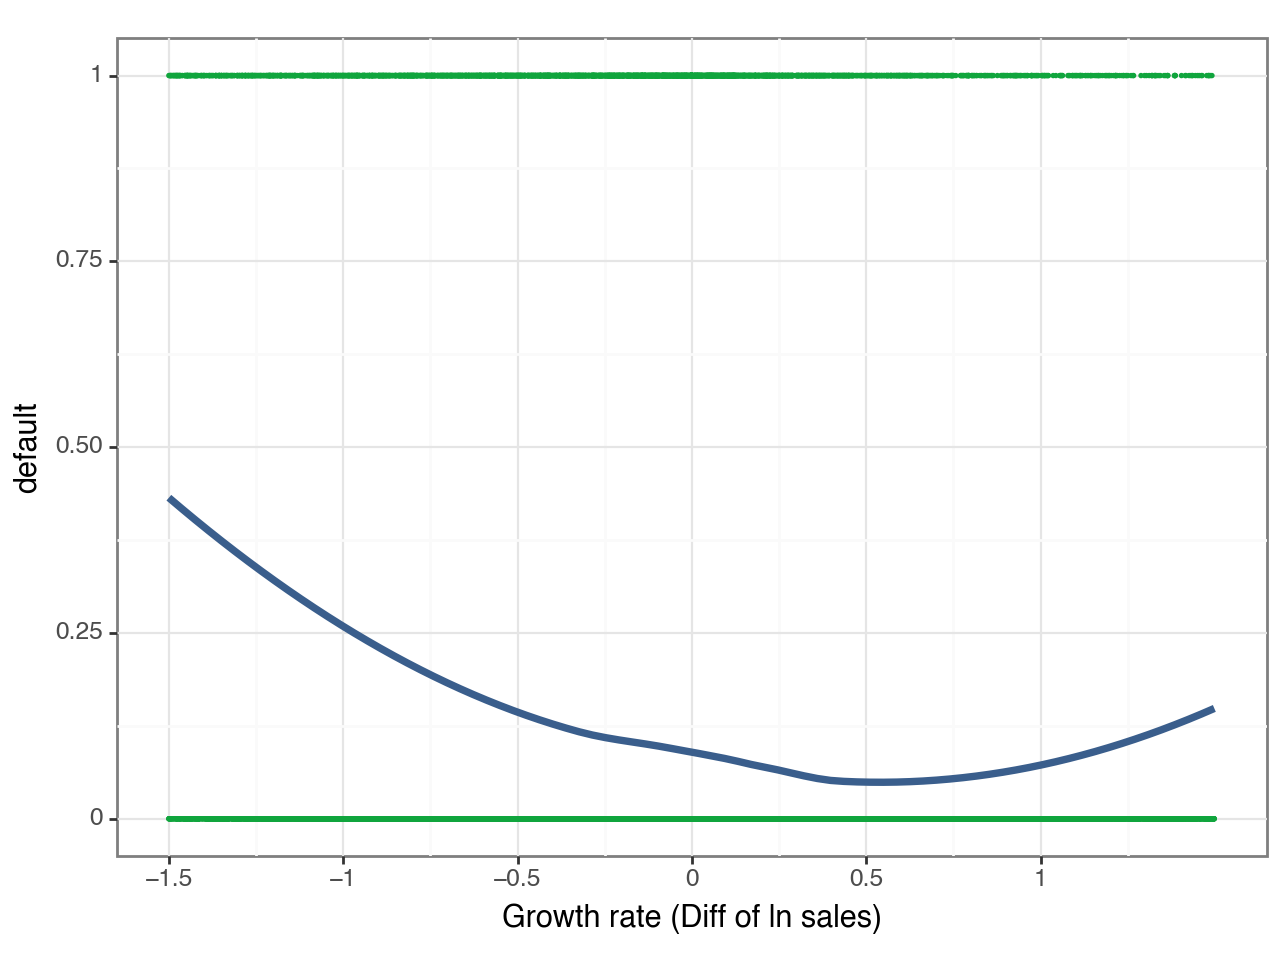

<Figure Size: (640 x 480)>

In [250]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="default"))
    + geom_point(size=0.1, color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="default")
    + scale_x_continuous(limits=(-1.5, 1.5), breaks=seq(-1.5, 1.5, by=0.5))
    + theme_bw()
)


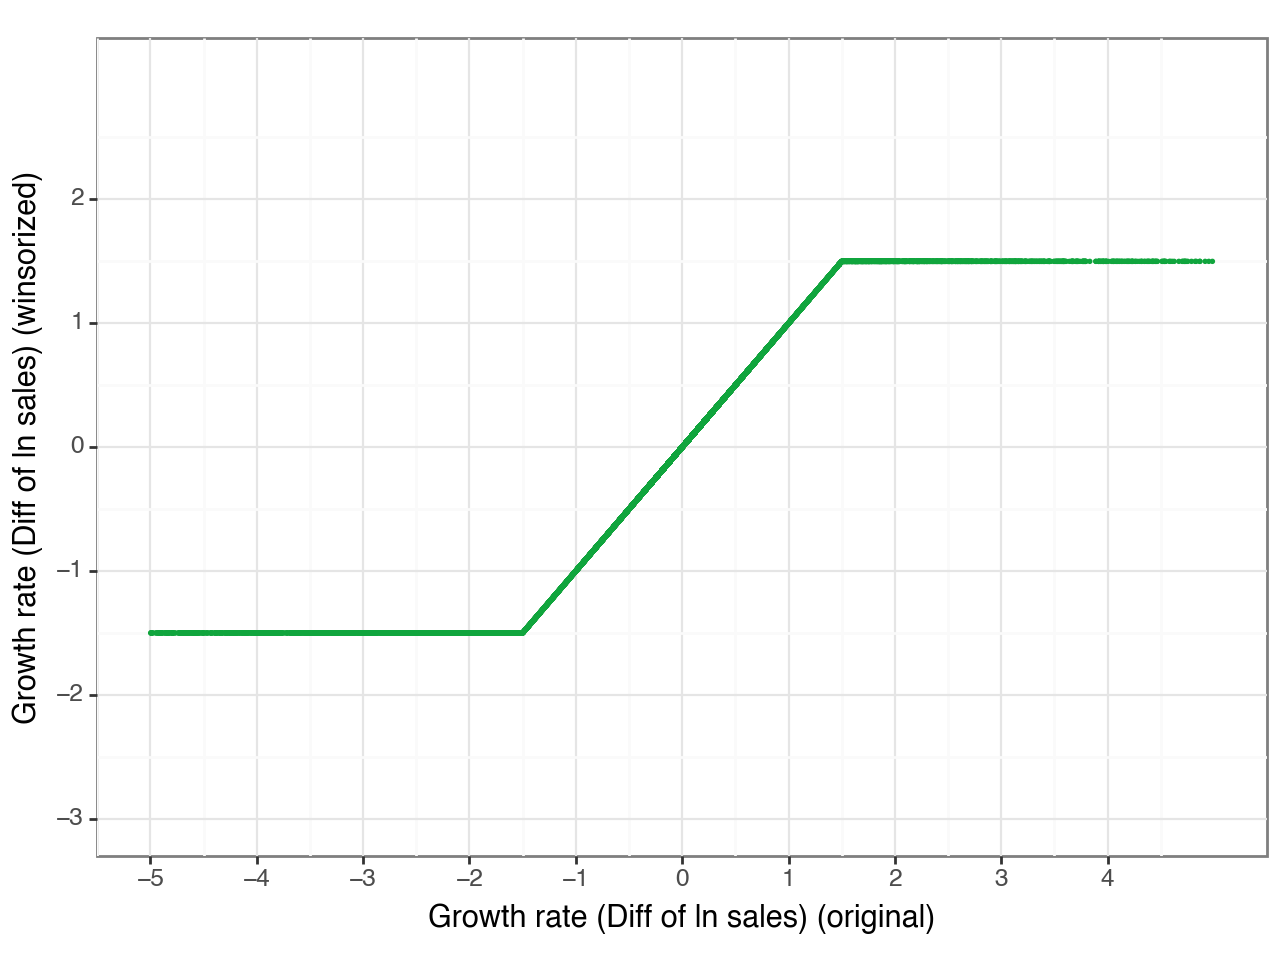

<Figure Size: (640 x 480)>

In [251]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="d1_sales_mil_log_mod"))
    + geom_point(size=0.1, color=color[1])
    + labs(
        x="Growth rate (Diff of ln sales) (original)",
        y="Growth rate (Diff of ln sales) (winsorized)",
    )
    + scale_x_continuous(limits=(-5, 5), breaks=seq(-5, 5, by=1))
    + scale_y_continuous(limits=(-3, 3), breaks=seq(-3, 3, by=1))
    + theme_bw()
)


In [252]:
data.shape

(57430, 118)

In [253]:
data.describe()

,year,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,...,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,labor_avg_mod,flag_miss_labor_avg,sales_mil_log_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq
count,57430.000000,5.743000e+04,5.743000e+04,5.743000e+04,5.743000e+04,5.743000e+04,5.743000e+04,5.743000e+04,5.743000e+04,5.743000e+04,...,57430.000000,57430.000000,57430.000000,57430.000000,57430.000000,5.743000e+04,57430.000000,57430.000000,57430.000000,57430.000000
mean,2013.008271,1.534906e+11,9.429816e+03,1.070026e+05,8.955437e+04,5.395260e+02,1.920617e+03,1.390498e+03,1.543247e+05,8.819268e+03,...,0.005293,0.107540,0.262319,0.653610,0.185339,1.177960e+01,0.040101,0.024621,-0.006521,0.300966
std,0.819233,1.378225e+11,4.773169e+04,6.636545e+05,4.930221e+05,1.191592e+04,5.878577e+04,5.897446e+04,1.348614e+06,1.457433e+05,...,0.072564,0.309801,0.439899,1.436903,0.388575,1.026138e+01,0.196198,0.154969,0.548570,0.614069
min,2012.000000,1.001541e+06,-1.489630e+04,0.000000e+00,-8.759259e+03,-8.496296e+03,-1.470000e+04,-1.569122e+06,0.000000e+00,-1.487044e+07,...,0.000000,0.000000,0.000000,0.083333,0.000000,3.087363e-09,0.000000,0.000000,-1.500000,0.000000
25%,2012.000000,2.903495e+10,1.481481e+02,3.733333e+03,3.848148e+03,0.000000e+00,0.000000e+00,0.000000e+00,3.888889e+02,-5.188889e+03,...,0.000000,0.000000,0.000000,0.152778,0.000000,3.715176e+00,0.000000,0.000000,-0.156533,0.001555
50%,2013.000000,1.148123e+11,9.777778e+02,1.275185e+04,1.547037e+04,0.000000e+00,0.000000e+00,0.000000e+00,5.266667e+03,5.259259e+02,...,0.000000,0.000000,0.000000,0.340278,0.000000,9.296021e+00,0.000000,0.000000,0.000000,0.030843
75%,2014.000000,2.571439e+11,4.318519e+03,4.434630e+04,5.063241e+04,0.000000e+00,0.000000e+00,0.000000e+00,4.403241e+04,5.588889e+03,...,0.000000,0.000000,1.000000,0.652610,0.000000,1.681664e+01,0.000000,0.000000,0.189284,0.208642
max,2014.000000,4.641050e+11,3.570863e+06,8.808707e+07,5.128913e+07,1.913111e+06,1.197874e+07,1.197874e+07,1.594445e+08,7.670470e+06,...,1.000000,1.000000,1.000000,46.354168,1.000000,4.771708e+01,1.000000,1.000000,1.500000,2.250000


Several Python libraries are imported, including matplotlib, patsy, scikit-learn, and statsmodels. These models are essential for predicting default status based on the dataset's features and evaluating their performance using metrics like mean squared error, ROC-AUC score, and confusion matrix.
Helper functions are defined to facilitate regression analysis and model evaluation. These functions calculate regression metrics and coefficients and summarize cross-validated model performance.

In [254]:
import matplotlib.pyplot as plt
import patsy
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
)
from sklearn.metrics import (
    auc,
    brier_score_loss,
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

#### 1.5 Define helper functions

In [255]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": model.intercept_},
        ignore_index=True,
    )
    return coef_matrix


def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)


def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})

    plot = (
        ggplot(all_coords, aes(x="fpr", y="tpr"))
        + geom_line(color=color[0], size=0.7)
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + scale_y_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0, 0.01))
        + scale_x_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0.01, 0))
        + theme_bw()
    )
    return plot


def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    t = optimal_threshold
    l = curr_exp_loss

    plot = (
        ggplot(all_coords_copy, aes(x="thresholds", y="loss"))
        + geom_line(color=color[0], size=0.7)
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + coord_cartesian(xlim=(0, 1))
        + geom_vline(xintercept=t, color=color[0])
        + annotate(
            geom="text",
            x=t - 0.01,
            y=max(all_coords_copy.loss) - 0.4,
            label="best threshold: " + str(round(t, 2)),
            colour=color[1],
            angle=90,
            size=7,
        )
        + annotate(geom="text", x=t + 0.06, y=l, label=str(round(l, 2)), size=7)
        + theme_bw()
    )
    return plot


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = (
        ggplot(all_coords_copy, aes(x="sp", y="se"))
        + geom_line(color=color[0], size=0.7)
        + scale_y_continuous(breaks=seq(0, 1.1, by=0.1))
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + geom_point(data=pd.DataFrame({"sp": [sp], "se": [se]}))
        + annotate(
            geom="text",
            x=sp,
            y=se + 0.03,
            label=str(round(sp, 2)) + ", " + str(round(se, 2)),
            size=7,
        )
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + theme_bw()
    )
    return plot


### 2. Model building

#### 2.1 Define variable sets 

In this section, we define various sets of variables that will be used in building predictive models for assessing default risk.

 *Main firm variables*
 
This set comprises fundamental financial variables related to the company's current assets, liabilities, income, expenses, and equity. These variables provide essential insights into the firm's financial health.

In [256]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "sales",
    "share_eq",
    "subscribed_cap",
]

*Further financial variables*

These sets contain additional financial variables derived from the balance sheet and income statement. They include ratios, quality indicators, and flags indicating specific financial conditions or anomalies.

In [257]:
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad",
]

 *Flag variables*

In [258]:
engvar3 = []
for col in data.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
    ):
        engvar3.append(col)

*Growth variables*

This set includes variables related to the growth rate of sales and associated flags indicating significant changes or anomalies in sales growth.

In [259]:
d1 = [
    "d1_sales_mil_log_mod",
    "d1_sales_mil_log_mod_sq",
    "flag_low_d1_sales_mil_log",
    "flag_high_d1_sales_mil_log",
]

*Human capital related variables*

These variables capture aspects related to human resources, such as CEO age, gender diversity, labor metrics, and indicators of foreign management.

In [260]:
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]

 *Firms history related variables*
 
This set includes variables related to the firm's historical performance and characteristics, such as age, geographical location, and urbanization status.

In [261]:
firm = ["age", "age2", "new", "C(m_region_loc)", "C(urban_m)"]

*Interactions for logit, LASSO*

These sets contain interaction terms between different variable groups, allowing the models to capture potential nonlinear relationships or synergies between predictors.

In [262]:
interactions1 = [
    "C(ind2_cat)*age",
    "C(ind2_cat)*age2",
    "C(ind2_cat)*d1_sales_mil_log_mod",
    "C(ind2_cat)*sales_mil_log",
    "C(ind2_cat)*ceo_age",
    "C(ind2_cat)*foreign_management",
    "C(ind2_cat)*female",
    "C(ind2_cat)*C(urban_m)",
    "C(ind2_cat)*labor_avg_mod",
]
interactions2 = [
    "sales_mil_log*age",
    "sales_mil_log*female",
    "sales_mil_log*profit_loss_year_pl",
    "sales_mil_log*foreign_management",
]

#### 2.2 Model setups

1. Simple Logit models

These setups define specific combinations of variables for different model specifications, ranging from simple logistic regression models to more complex setups incorporating various sets of predictors and interactions.

In [263]:
M1 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl",
    "C(ind2_cat)",
]
M2 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl",
    "fixed_assets_bs",
    "share_eq_bs",
    "curr_liab_bs ",
    "curr_liab_bs_flag_high ",
    "curr_liab_bs_flag_error",
    "age",
    "foreign_management",
]
M3 = ["sales_mil_log", "sales_mil_log_sq"] + firm + engvar + d1
M4 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
)
M5 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
    + interactions1
    + interactions2
)

2. Logit+LASSO

This set includes variables intended for logistic regression models with LASSO regularization, which helps in feature selection and model regularization.

In [264]:
logit_lasso_vars = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + firm
    + qualityvars
    + interactions1
    + interactions2
)

3. Random Forest (no interactions, no modified features)

These sets define variables for decision tree-based models, such as Random Forest (RF), which are capable of handling nonlinear relationships and interactions.

In [265]:
rfvars = ["sales_mil", "d1_sales_mil_log"] + rawvars + hr + firm + qualityvars

Additionally, the data is split into separate training and holdout datasets (data_train and data_holdout) based on the year and industry code, facilitating model training and evaluation on independent datasets.

By defining these variable sets and datasets, we establish the foundation for building and evaluating predictive models for default risk assessment using a variety of machine learning techniques.

#### 2.3 Separate train and holdout data

In [266]:
data_train = data.query("year == 2014 & ind2 != 26")

In [267]:
data_train.shape

(18508, 118)

In [268]:
data_holdout.shape

(1037, 118)

In [269]:
print("Total")
print(data["default"].value_counts(normalize=True))
print("Train")
print(data_train["default"].value_counts(normalize=True))
print("Holdout")
print(data_holdout["default"].value_counts(normalize=True))


Total
default
0    0.893801
1    0.106199
Name: proportion, dtype: float64
Train
default
0    0.900097
1    0.099903
Name: proportion, dtype: float64
Holdout
default
0    0.945998
1    0.054002
Name: proportion, dtype: float64


#### 2.4 Predict probabilities with logit and Lasso with CV

To predict probabilities with logistic regression and LASSO using 5-fold cross-validation, we follow these steps:
- We specify a 5-fold cross-validation method (k) to evaluate the models' performance.
- We define a list of variable sets (logit_model_vars) for different logistic models (M1 to M5).
- For each model specification, we fit logistic regression models using cross-validation (LogisticRegressionCV) with the specified parameters.
- We calculate the root mean squared error (RMSE) on the test set for each fold of cross-validation.

In [270]:
k = KFold(n_splits=5, shuffle=True, random_state=42)

#### a) cross validate logit models

Set up X-vars

In [271]:
logit_model_vars = [M1, M2, M3, M4, M5]

Set up Logit model object

No regularisation needed so setting the paremeter to very high value

In [272]:
C_value_logit = [1e20]

In [273]:
logit_models = dict()
CV_RMSE_folds = dict()

for i, model_vars in enumerate(logit_model_vars):

    model_equation = "default~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_brier = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_brier.fit(X_train, y_train)

    # Calculate RMSE on test for each fold
    CV_RMSE_folds["M" + str(i + 1)] = np.sqrt(
        -1 * logit_models["M" + str(i + 1)].scores_[1].ravel()
    )

In [274]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5
0,0.277933,0.274837,0.284167,0.274714,0.271417
1,0.294379,0.291838,0.291741,0.289749,0.289469
2,0.285858,0.279894,0.284472,0.276951,0.276921
3,0.283935,0.279251,0.282642,0.276400,0.275666
4,0.287306,0.282100,0.286931,0.278743,0.279604


#### b) Logit + LASSO

- We specify the model equation using all the variables intended for logistic regression with LASSO regularization (logit_lasso_vars).
- We normalize the input variables and set up regularization parameters for LASSO.
- We initialize and fit logistic regression with LASSO using cross-validation (LogisticRegressionCV) with the specified parameters.
- We calculate the mean cross-validated RMSE (after converting negative Brier scores) and select the best lambda for LASSO regularization.
- We extract the cross-validated test RMSE for the LASSO model with the best lambda

In [275]:
model_equation = "default~" + "+".join(logit_lasso_vars)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

In [276]:
normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train),
    columns=X_train.design_info.column_names,
)

Set regularization parameters

In [277]:
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5
C_values = [
    1 / (l * n_obs) for l in lambdas
]  # Cs are the inverse of regularization strength

Initialize and fit Logit Lasso

In [278]:
logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)

logit_models["LASSO"] = logLasso_brier.fit(normalized_logitvars, y_train)

See CV-fold RMSE-s (negative brier score)

In [279]:
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso["mean_cv_score"] = np.sqrt(cv_summary_lasso["mean_cv_score"] * -1)
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.000675,0.316120
1,0.046416,0.001455,0.297152
2,0.021544,0.003135,0.283298
3,0.010000,0.006754,0.278403
4,0.004642,0.014551,0.276928
5,0.002154,0.031349,0.276193
6,0.001000,0.067538,0.276151
7,0.000464,0.145507,0.276456
8,0.000215,0.313485,0.276749
9,0.000100,0.675384,0.276976


Save best lambda's index for later use

In [280]:
best_lambda_i = cv_summary_lasso["mean_cv_score"].idxmin()

Extract CV test RMSE for the Lasso with best lambda

In [281]:
CV_RMSE_folds["LASSO"] = np.sqrt(
    -1 * logit_models["LASSO"].scores_[1][:, best_lambda_i]
)

#### 2.5  AUC, Calibration Curve, Confusion Matrix, ROC

- We calculate the area under the ROC curve (AUC) for both logistic regression and LASSO models.
- For logistic regression, we use the same procedure as for RMSE calculation, but with the scoring parameter set to "roc_auc".
- For LASSO, we fit a logistic regression model with LASSO using cross-validation and calculate the AUC for the best lambda.
- We compile a summary frame containing the number of coefficients, cross-validated RMSE, and AUC for each model.


First, for logits

In [282]:
CV_AUC_folds = dict()
for i, model_vars in enumerate(logit_model_vars):

    model_equation = "default~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_auc = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="roc_auc",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_auc.fit(X_train, y_train)

    # Calculate AUC on test for each fold
    CV_AUC_folds["M" + str(i + 1)] = logit_models["M" + str(i + 1)].scores_[1].ravel()

For Lasso

In [283]:
logLasso_auc = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)

CV_AUC_folds["LASSO"] = logLasso_auc_fitted.scores_[1][
    :, cv_summary_lasso["mean_cv_score"].idxmin()
]

Put a summary frame together

In [284]:
model_fits = pd.DataFrame(logit_models, index=["Model fit"]).T

summary = (
    model_fits["Model fit"]
    .apply(lambda x: x.n_features_in_)
    .to_frame(name="Number of Coefficients")
)

summary.loc["LASSO", "Number of Coefficients"] = len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

summary["CV RMSE"] = pd.DataFrame(CV_RMSE_folds).T.mean(axis=1)
summary["CV AUC"] = pd.DataFrame(CV_AUC_folds).T.mean(axis=1)

In [285]:
sum(x != 0 for x in model_fits.loc["LASSO"].values[0].coef_[0].tolist())

81

In [286]:
len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

81

In [287]:
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,12,0.285882,0.735093
M2,12,0.281584,0.772332
M3,29,0.285991,0.752445
M4,73,0.279311,0.799807
M5,154,0.278616,0.798916
LASSO,81,0.276076,0.806215


#### 2.6 Estimate RMSE on holdout with the best model

We select the best model based on the summary frame and estimate the RMSE on the holdout dataset.
For the sake of simplicity, we choose model `M2` as the best model.
We compute the predicted probabilities for default on the holdout dataset using the selected model and calculate the RMSE between the predicted probabilities and the actual defaults.
This process allows us to evaluate the performance of logistic regression and LASSO models using cross-validation and assess their predictive accuracy on unseen data using holdout validation.


In [288]:
best_logit = logit_models["M2"]
model_equation = "default~" + "+".join(M2)
_, X_holdout = patsy.dmatrices(model_equation, data_holdout)

Best logit holdout RMSE


In [289]:
data_holdout["best_logit_pred_proba"] = best_logit.predict_proba(X_holdout)[:, 1]

round(rmse(data_holdout["best_logit_pred_proba"], data_holdout["default"]), 3)

0.217

#### a) Calibration curve

A calibration curve assesses how well the estimated probabilities from the model align with the actual event probabilities. Here's how we create a calibration plot:

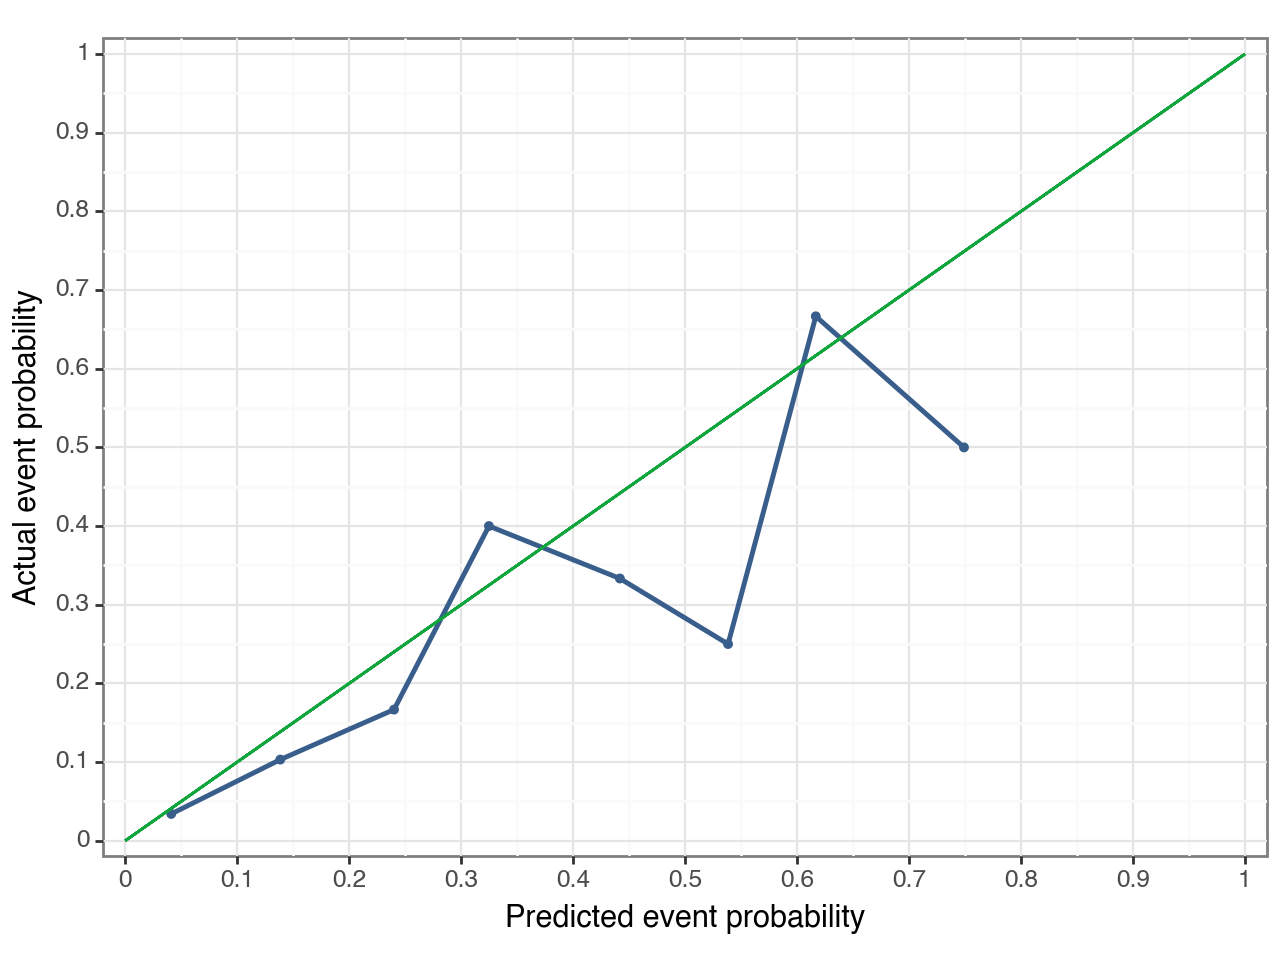

<Figure Size: (640 x 480)>

In [290]:
create_calibration_plot(
    data_holdout,
    #file_name="logit-m2-calibration",
    prob_var="best_logit_pred_proba",
    actual_var="default",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
)


This function will generate a calibration plot comparing the estimated probabilities (best_logit_pred_proba) against the actual event probabilities (default) on the holdout dataset.

#### b) Confusion table with different tresholds

A confusion matrix summarizes the performance of a classification model by presenting the counts of true positive, true negative, false positive, and false negative predictions. You can generate confusion matrices for different thresholds as follows:

Default: the threshold 0.5 is used to convert probabilities to binary classes

In [291]:
logit_class_prediction = best_logit.predict(X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0], " (no default): ", counts[0])
print(values[1], " (default): ", counts[1])

0.0  (no default):  1028
1.0  (default):  9


Confusion matrix: summarize different type of errors and successfully predicted cases

positive = "yes": explicitly specify the positive case

In [292]:
cm_object1 = confusion_matrix(
    data_holdout["default"], logit_class_prediction, labels=[0, 1]
)
cm1 = pd.DataFrame(
    cm_object1,
    index=["Actul no defaul", "Actual default"],
    columns=["Predicted no default", "Predicted default"],
)
cm1

,Predicted no default,Predicted default
Actul no defaul,976,5
Actual default,52,4


In [293]:
# we can apply different thresholds

# 0.5 same as before
holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < 0.5, 0, 1)
cm_object1b = confusion_matrix(
    data_holdout["default"], holdout_prediction, labels=[0, 1]
)
cm1b = pd.DataFrame(
    cm_object1b,
    index=["Actul no defaul", "Actual default"],
    columns=["Predicted no default", "Predicted default"],
)
cm1b

,Predicted no default,Predicted default
Actul no defaul,976,5
Actual default,52,4


These code snippets will provide confusion matrices for the default threshold (0.5) and the threshold based on the mean of predicted probabilities.

In [294]:
mean_predicted_default_prob = np.mean(data_holdout["best_logit_pred_proba"])
round(mean_predicted_default_prob, 3)

0.067

In [295]:
holdout_prediction = np.where(
    data_holdout["best_logit_pred_proba"] < mean_predicted_default_prob, 0, 1
)
cm_object2 = confusion_matrix(
    data_holdout["default"], holdout_prediction, labels=[0, 1]
)
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actul no defaul", "Actual default"],
    columns=["Predicted no default", "Predicted default"],
)
cm2

,Predicted no default,Predicted default
Actul no defaul,729,252
Actual default,20,36


#### c) Visualize ROC (with thresholds in steps) on holdout

We can visualize the Receiver Operating Characteristic (ROC) curve on the holdout dataset to assess the model's performance across different thresholds. 

In [296]:
thresholds = np.arange(0.05, 0.76, 0.05)
#thresholds = sorted(np.geomspace(0.95, 0.05, num=17)) # set these treshold values to get even points in the plot
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < thr, 0, 1)
    cm_thr = confusion_matrix(data_holdout["default"], holdout_prediction, labels=[0, 1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp / (tp + fn))
    false_positive_rates.append(fp / (fp + tn))

In [297]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {
        "thresholds": thresholds,
        "true_positive_rates": true_positive_rates,
        "false_positive_rates": false_positive_rates,
    }
)

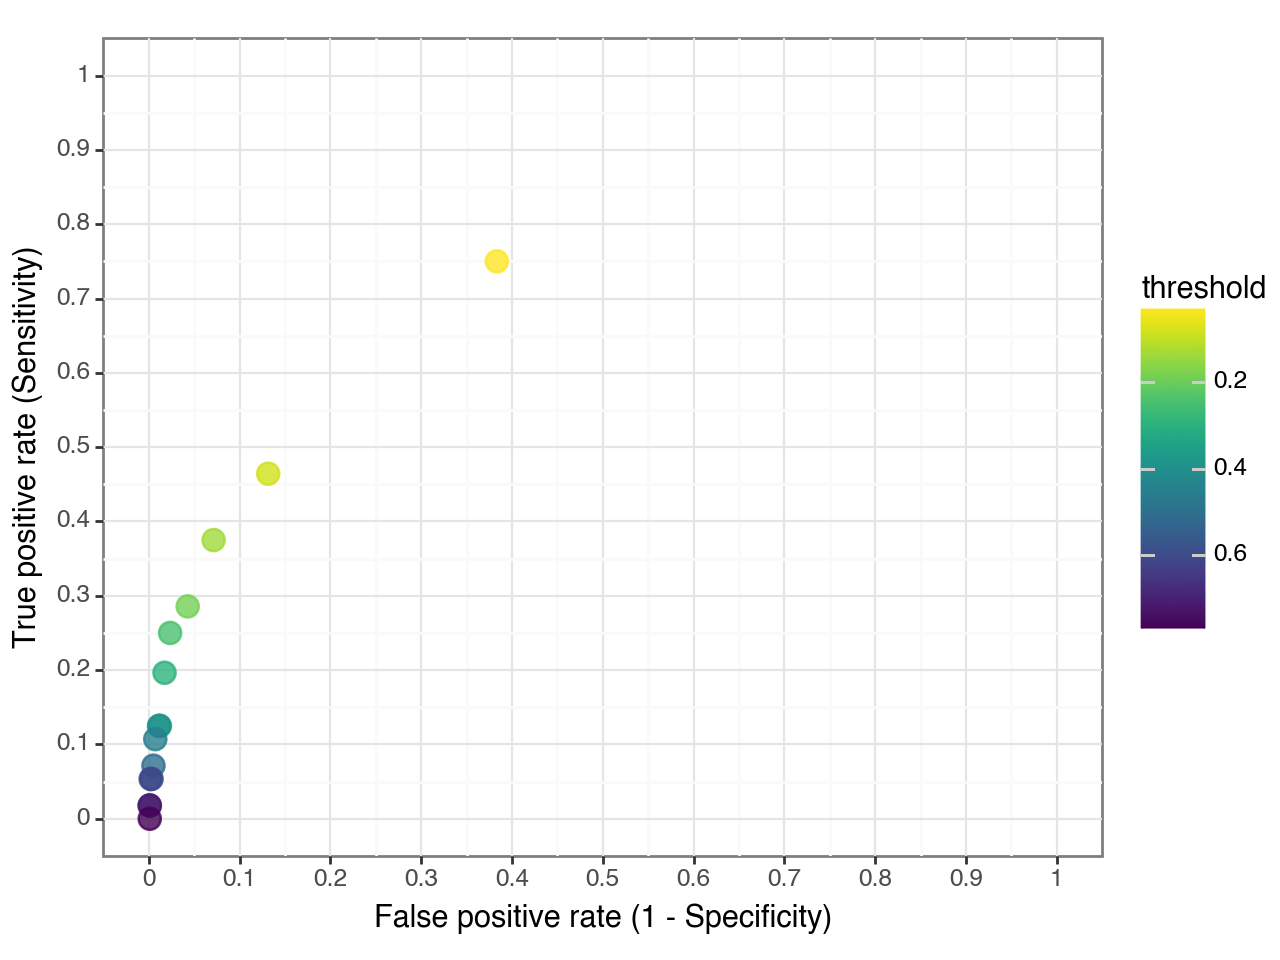

<Figure Size: (640 x 480)>

In [298]:
(
    ggplot(
        tpr_fpr_for_thresholds,
        aes(x="false_positive_rates", y="true_positive_rates", color="thresholds"),
    )
    + labs(
        x="False positive rate (1 - Specificity)", y="True positive rate (Sensitivity)"
    )
    + geom_point(size=4, alpha=0.8)
    + scale_color_continuous(trans="reverse", name="threshold")
    + scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + theme_bw()
    + theme(legend_position="right")
)

Continuous ROC on holdout with best model

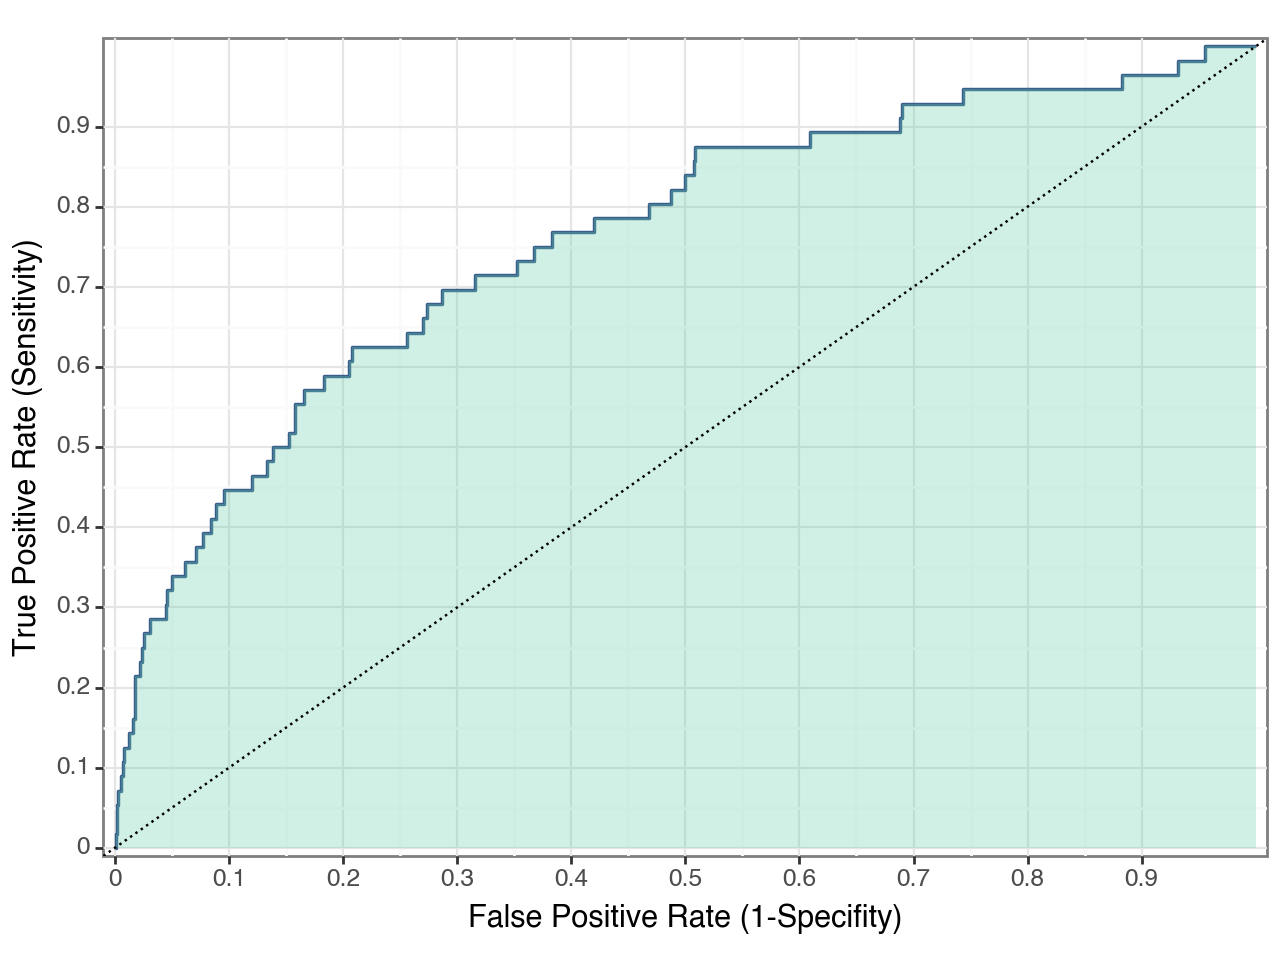

<Figure Size: (640 x 480)>

In [299]:
create_roc_plot(data_holdout["default"], data_holdout["best_logit_pred_proba"])

#### 2.7 Minimazation of the loss function

To find the optimal threshold that minimizes the loss function, we can iterate through different models and folds, calculating the cost associated with false negative and false positive classifications for each threshold. Then, select the threshold with the lowest overall cost.

In [300]:
FP = 3
FN = 15
cost = FN / FP

The prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))


In [301]:
prevelance = y_train.sum() / len(y_train)

In [302]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss = []

    if model_name != "LASSO":
        _, X = patsy.dmatrices("default ~" + "+".join(logit_model_vars[i]), data_train)
        X = pd.DataFrame(X)
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = data_train["default"].iloc[test_index]
        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate
                        + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                    ),
                    thresholds,
                )
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(
            y_fold, threshold_prediction, labels=[0, 1]
        ).ravel()
        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold + 1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame(
        {
            "false_pos": false_pos_rate * sum(y_fold == 0),
            "true_pos": true_pos_rate * sum(y_fold == 1),
            "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
            "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
            "pos": sum(y_fold == 1),
            "neg": sum(y_fold == 0),
            "n": len(y_fold),
            "thresholds": thresholds,
        }
    )

    fold5_all_coords[model_name] = all_coords

In [303]:
summary_with_lossfnc = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model", "Avg of optimal thresholds"]
)
summary_with_lossfnc["Threshold for Fold5"] = fold5_threshold.values()
summary_with_lossfnc["Avg expected loss"] = expected_loss_cv.values()
summary_with_lossfnc["Expected loss for Fold5"] = fold5_expected_loss.values()


In [304]:
summary_with_lossfnc

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,M1,0.156411,0.146799,1.150369,1.177790
1,M2,0.182375,0.174384,1.107251,1.103215
2,M3,0.166756,0.151082,1.176464,1.211024
3,M4,0.150728,0.159260,1.060730,1.074845
4,M5,0.149452,0.131489,1.055867,1.065928
5,LASSO,0.177636,0.196406,1.043062,1.048095


Create loss plot based on Fold5 in CV 

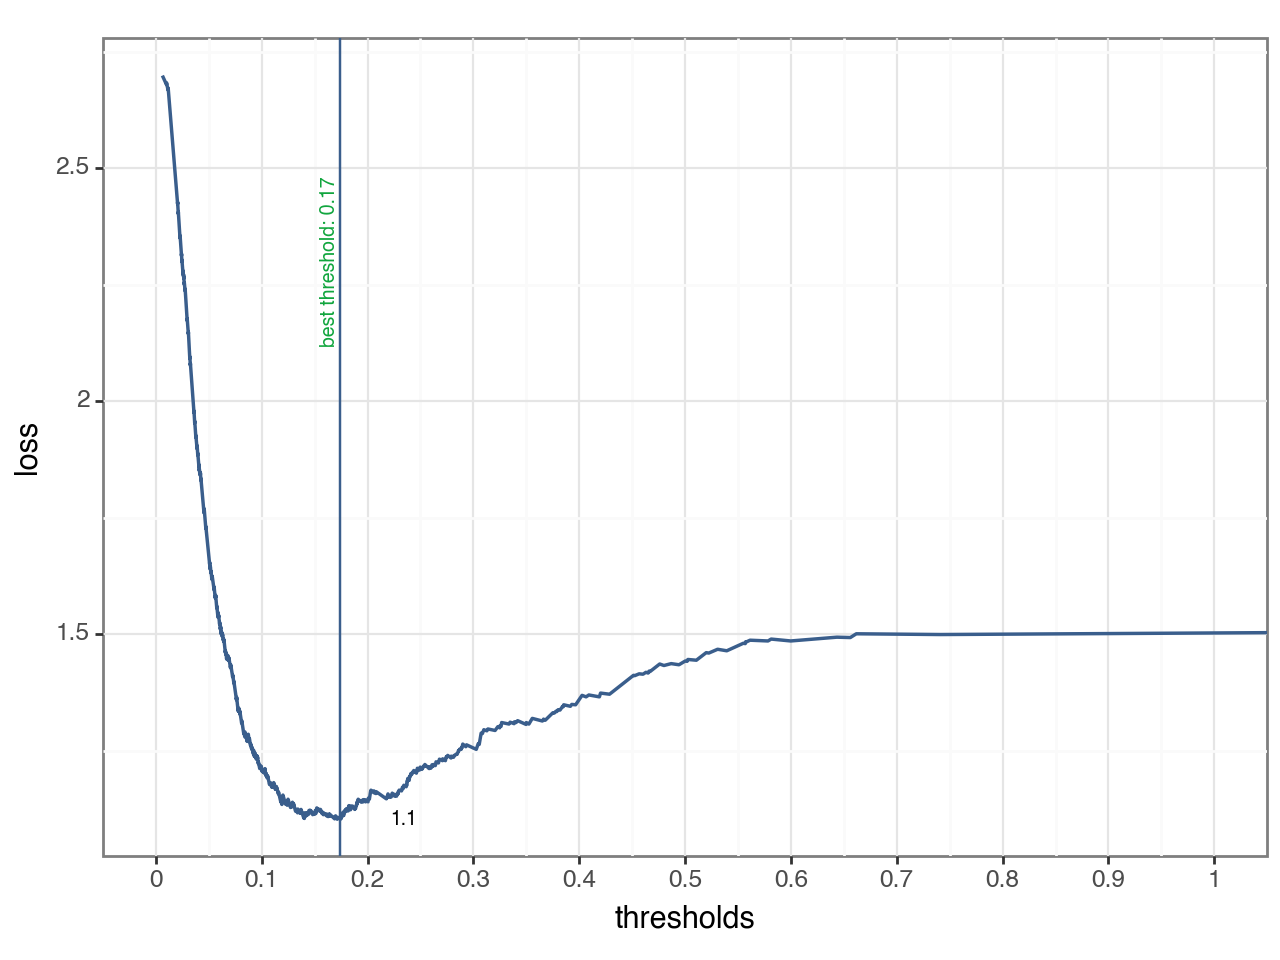

<Figure Size: (640 x 480)>

In [305]:
model_to_plot = "M2"  # select model to plot
create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)

Create roc plot plot based on Fold5 in CV

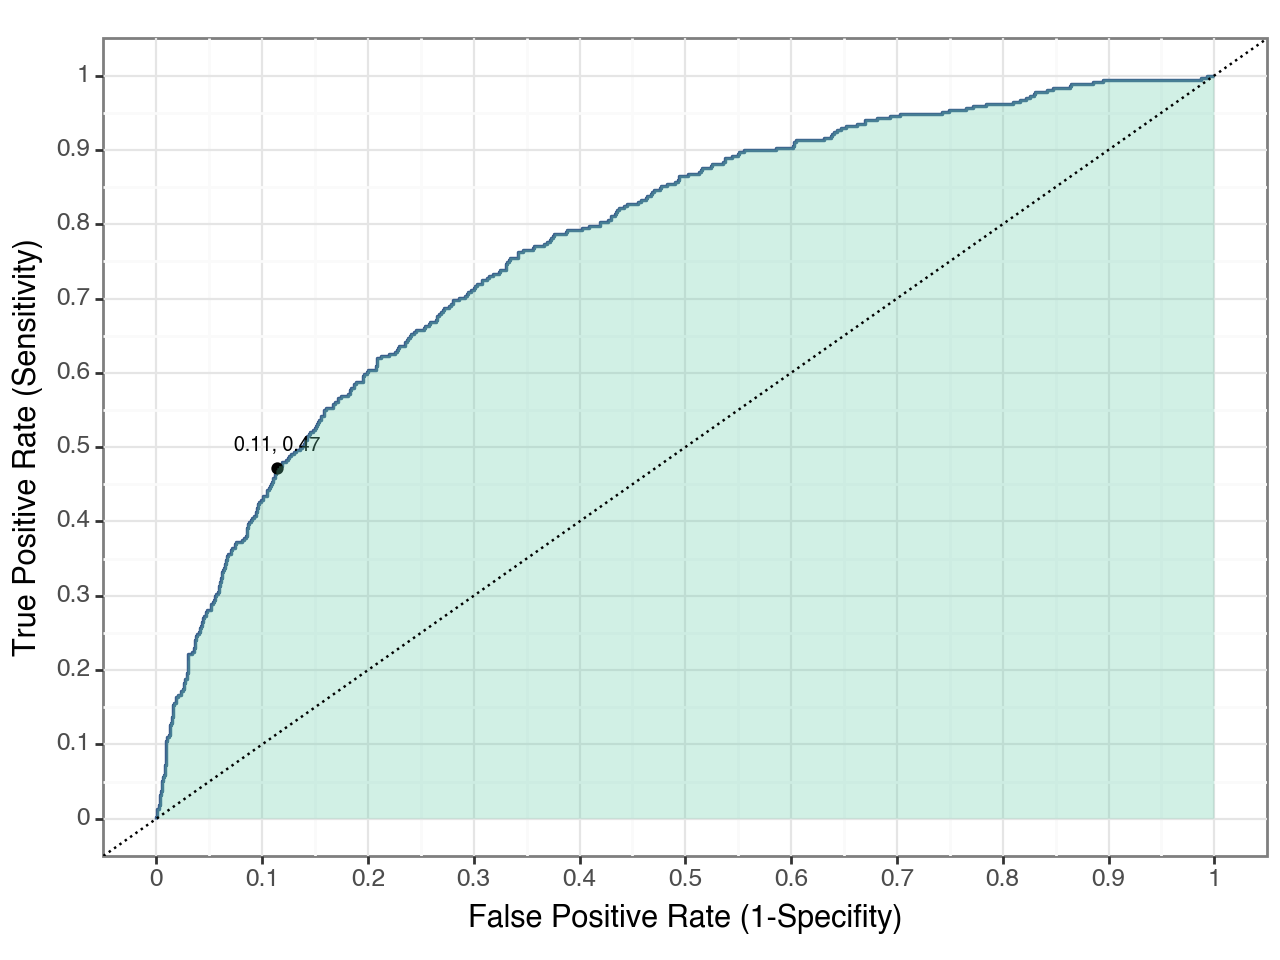

<Figure Size: (640 x 480)>

In [306]:
create_roc_plot_with_optimal(
    fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot]
)


Let's see our chosen model, M2's holdout expected loss

In [307]:
best_logit_optimal_treshold = best_thresholds_cv["M2"]

# Get expected loss on holdout
holdout_treshold = np.where(
    data_holdout["best_logit_pred_proba"] < best_logit_optimal_treshold, 0, 1
)
tn, fp, fn, tp = confusion_matrix(
    data_holdout["default"], holdout_treshold, labels=[0, 1]
).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(data_holdout["default"])
round(expected_loss_holdout, 3)

0.686

CM on holdout

In [308]:
cm_object3 = confusion_matrix(data_holdout["default"], holdout_treshold, labels=[0, 1])
cm3 = pd.DataFrame(
    cm_object3,
    index=["Actual no default", "Actual default"],
    columns=["Predicted no default", "Predicted default"],
)
cm3

,Predicted no default,Predicted default
Actual no default,934,47
Actual default,38,18


#### 2.8 Prediction with Random Forest

Now, as a final step, we employ a random forest classification to predict defaults. We will compare this model with previous Logit and Lasso models

In [309]:
y_train, rfvars_train = patsy.dmatrices("default~" + "+".join(rfvars), data_train)
y_holdout, rfvars_holdout = patsy.dmatrices("default~" + "+".join(rfvars), data_holdout)

#### a) Graph example for decision tree

We start by visualizing a decision tree as an example. Using the features "sales_mil", "profit_loss_year", and "foreign_management", we build a decision tree classifier and plot it to understand the decision-making process.

<Figure size 640x480 with 0 Axes>

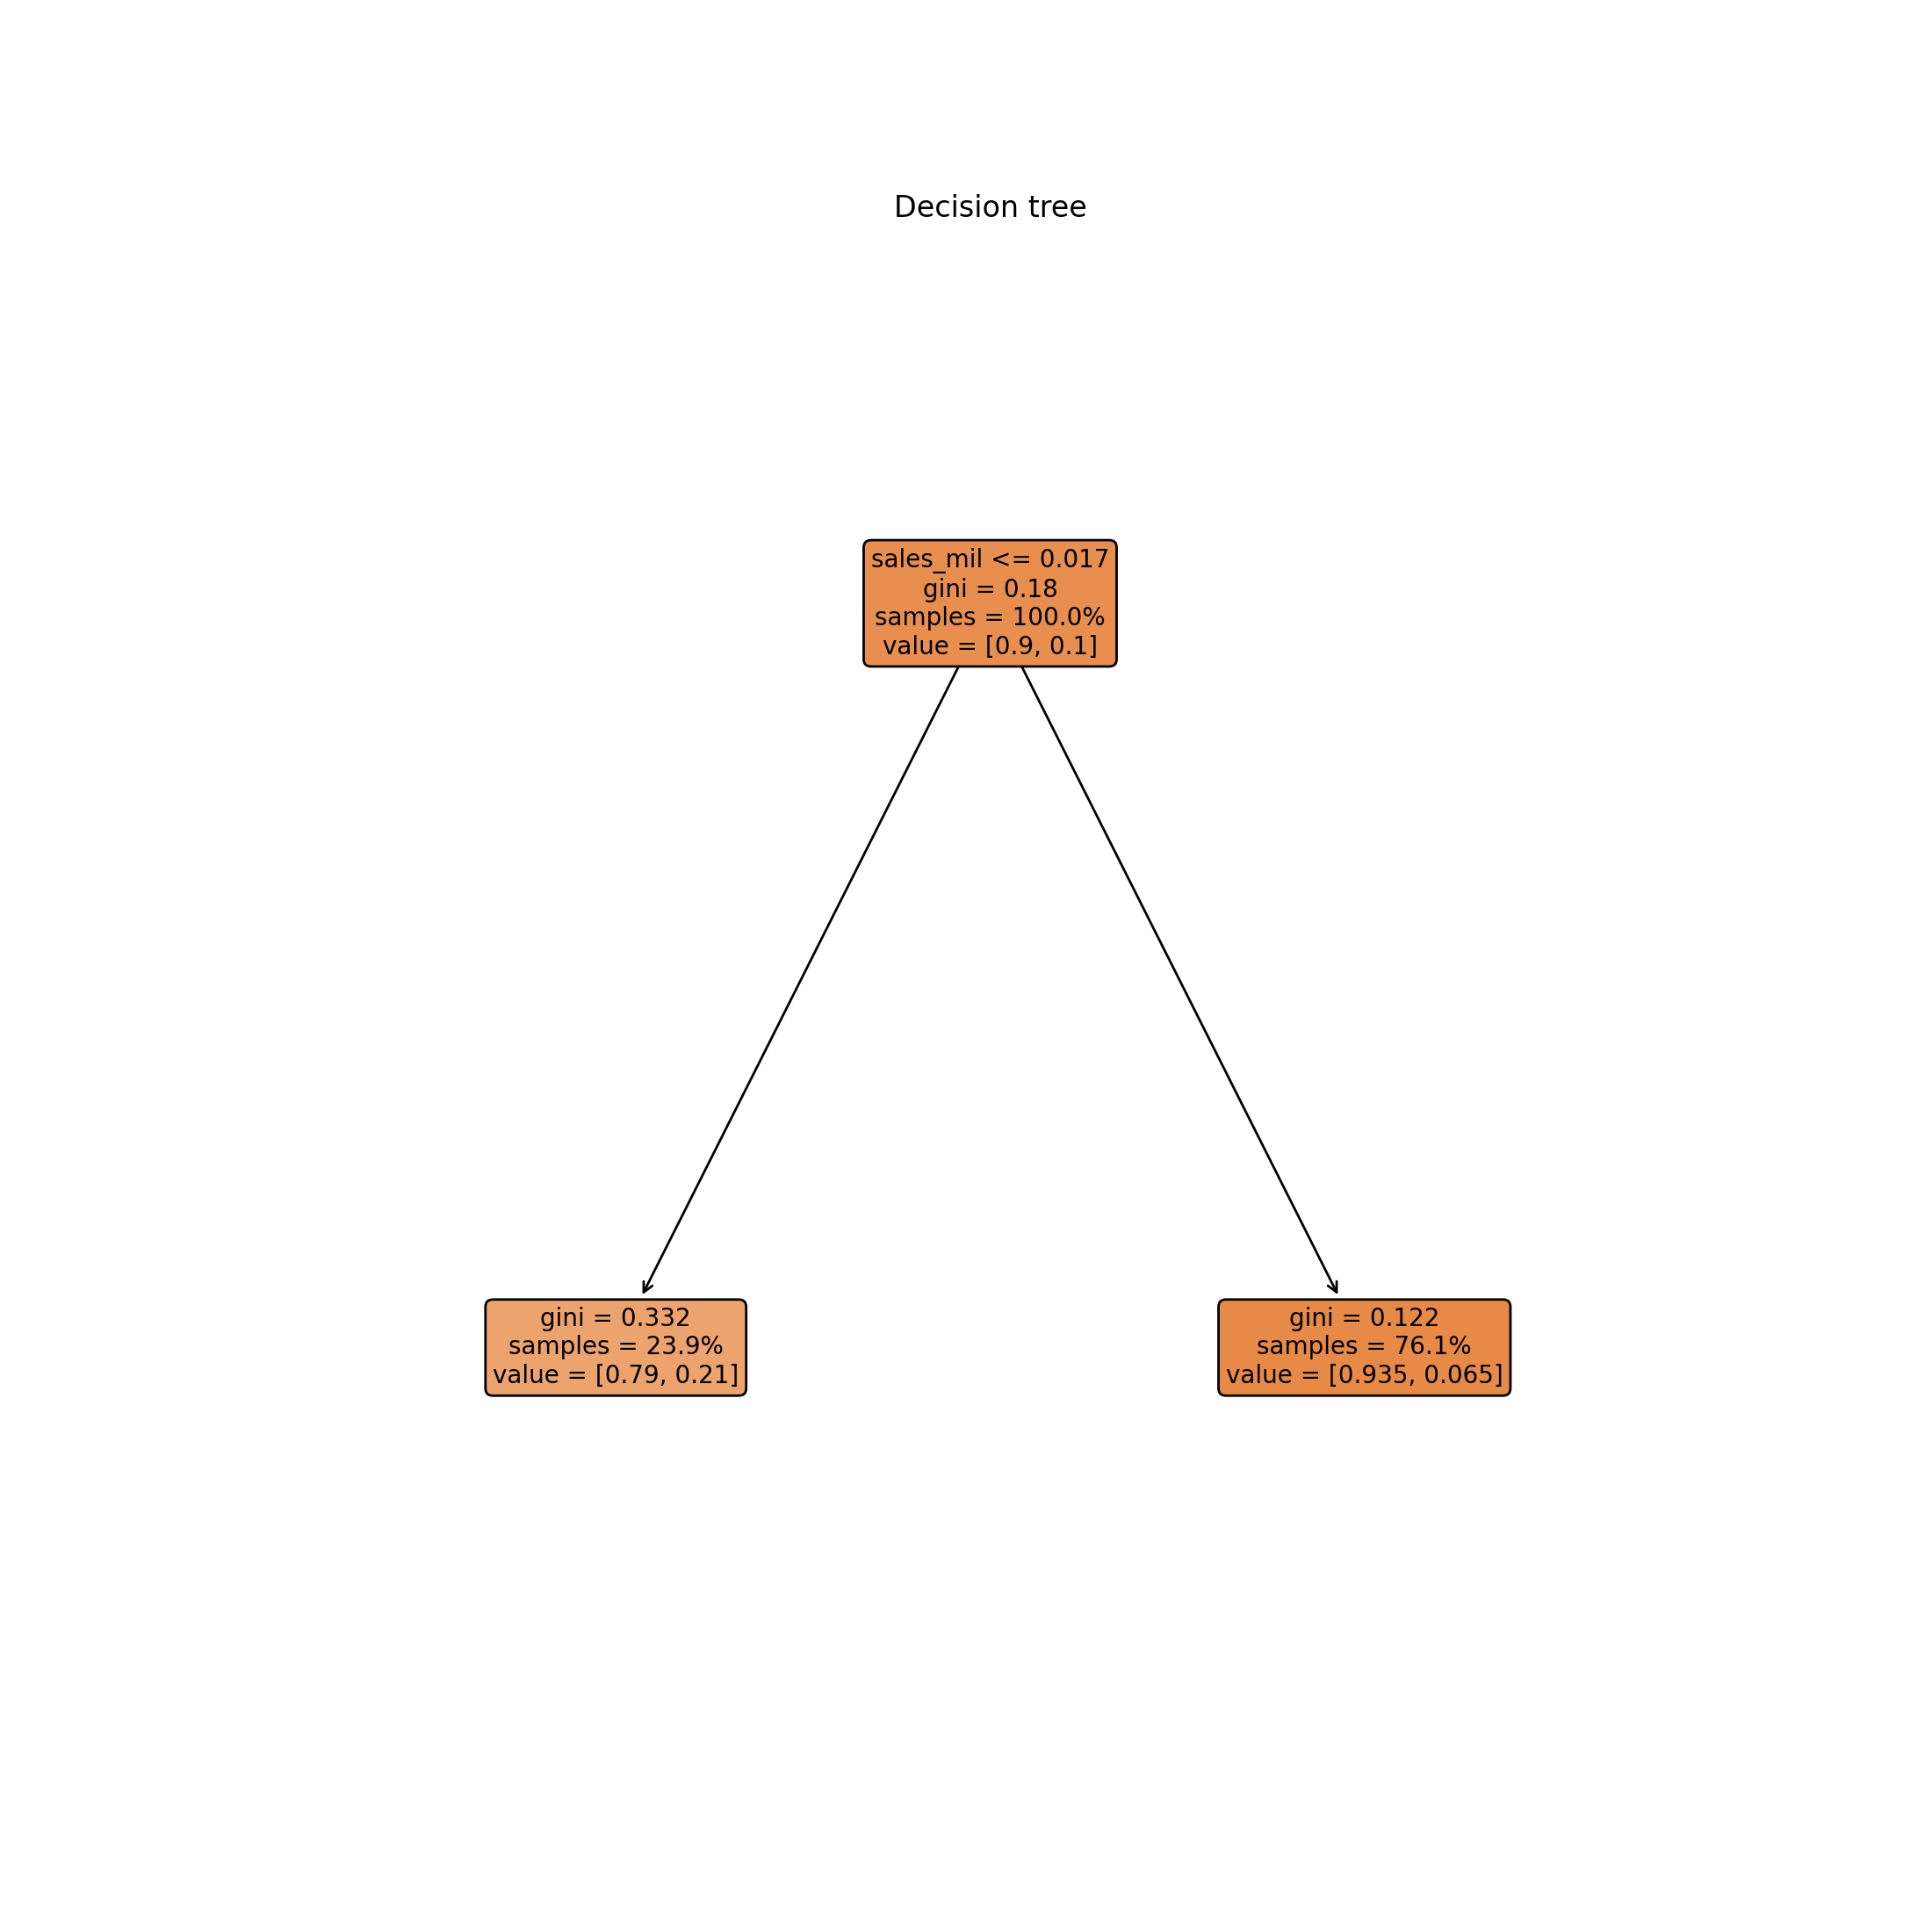

In [310]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

data_for_graph = data_train[["sales_mil", "profit_loss_year", "foreign_management"]]
rf_for_graph = DecisionTreeClassifier(
    ccp_alpha=0.0028, min_samples_leaf=100, max_depth=3, random_state=41
).fit(data_for_graph, y_train)

plt.figure()
plt.figure(figsize=(11, 11))
plot_tree(
    rf_for_graph,
    feature_names=data_for_graph.columns.tolist(),
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10,
)
plt.title("Decision tree")
plt.show()


#### b) Probability forest

Next, we create a random forest classifier to predict probabilities. We perform hyperparameter tuning using grid search with cross-validation and evaluate the model's performance using metrics such as ROC AUC and RMSE.

In [311]:
# Define parameter grid
grid = {
    "max_features": [5, 6, 7],
    "criterion": ["gini"],
    "min_samples_split": [11, 16],
} 

5 fold cross validation

In [312]:
# Create Random Forest Classifier
prob_forest = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)

# Perform grid search with cross-validation
prob_forest_grid = GridSearchCV(
    prob_forest,
    grid,
    cv=k,
    refit="roc_auc",
    scoring=["roc_auc", "neg_brier_score"],
)

# Fit the model
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

After model fitting, we extract and summarize important metrics such as optimal parameters, cross-validated RMSE, AUC, and expected loss.

Create CV summary table

In [313]:
prob_forest_cv_results = pd.DataFrame(
    {
        "max_features": prob_forest_fit.cv_results_["param_max_features"],
        "min_samples_split": prob_forest_fit.cv_results_["param_min_samples_split"],
        "cv_auc": prob_forest_fit.cv_results_["mean_test_roc_auc"],
        "cv_rmse": np.sqrt(
            prob_forest_fit.cv_results_["mean_test_neg_brier_score"] * -1
        ),
    }
)

prob_forest_cv_results

,max_features,min_samples_split,cv_auc,cv_rmse
0,5,11,0.834549,0.266607
1,5,16,0.835564,0.266482
2,6,11,0.834481,0.266574
3,6,16,0.834312,0.266558
4,7,11,0.833571,0.266810
5,7,16,0.834658,0.266636


Obtain optimal parameter values

In [314]:
best_mtry = prob_forest_fit.best_params_["max_features"]
best_min_node_size = prob_forest_fit.best_params_["min_samples_split"]
prob_forest_fit.best_params_


{'criterion': 'gini', 'max_features': 5, 'min_samples_split': 16}

Get average (ie over the folds) RMSE and AUC

In [315]:
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_mtry)
    & (prob_forest_cv_results.min_samples_split == best_min_node_size)
]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

In [316]:
summary.loc["RF", "Number of Coefficients"] = "n.a."
summary.loc["RF", "CV RMSE"] = prob_forest_best_results["cv_rmse"].values[0]
summary.loc["RF", "CV AUC"] = prob_forest_best_results["cv_auc"].values[0]
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,12.0,0.285882,0.735093
M2,12.0,0.281584,0.772332
M3,29.0,0.285991,0.752445
M4,73.0,0.279311,0.799807
M5,154.0,0.278616,0.798916
LASSO,81.0,0.276076,0.806215
RF,n.a.,0.266482,0.835564


Extract fold level RMSE and AUC

In [317]:
CV_RMSE_folds["RF"] = np.sqrt(
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_neg_brier_score")
    .loc[lambda x: x["rank_test_neg_brier_score"] == 1]
    .filter(like="split")
    .values[0]
    * -1
)
CV_AUC_folds["RF"] = (
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_roc_auc")
    .loc[lambda x: x["rank_test_roc_auc"] == 1]
    .filter(like="split")
    .values[0]
)

Take a look at foldwise RMSE and AUC

In [318]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.277933,0.274837,0.284167,0.274714,0.271417,0.268101,0.259484
1,0.294379,0.291838,0.291741,0.289749,0.289469,0.287711,0.276904
2,0.285858,0.279894,0.284472,0.276951,0.276921,0.274531,0.263534
3,0.283935,0.279251,0.282642,0.276400,0.275666,0.273729,0.265089
4,0.287306,0.282100,0.286931,0.278743,0.279604,0.276306,0.267081


In [319]:
pd.DataFrame(CV_AUC_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.744531,0.778101,0.727292,0.791814,0.805287,0.809934,0.836339
1,0.733844,0.755039,0.770628,0.790823,0.784622,0.785647,0.826621
2,0.747389,0.792001,0.770372,0.816005,0.811080,0.816130,0.843034
3,0.719709,0.758392,0.749091,0.791472,0.790250,0.803587,0.832978
4,0.729994,0.778127,0.744840,0.808919,0.803342,0.815774,0.838846


Now use loss function and search for best thresholds and expected loss over folds 

In [320]:
best_thresholds = list()
expected_loss = list()
rfvars_train = pd.DataFrame(rfvars_train)

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index, :]
    y_fold = data_train["default"].iloc[test_index]

    X_fold_train = rfvars_train.iloc[train_index, :]
    y_fold_train = data_train["default"].iloc[train_index]

    prob_forest_best = RandomForestClassifier(
        random_state=42,
        n_estimators=500,
        oob_score=True,
        criterion="gini",
        max_features=best_mtry,
        min_samples_split=best_min_node_size,
    )
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:, 1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate
                    + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                ),
                threshold,
            )
        ),
        key=lambda x: x[0],
        reverse=True,
    )[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(
        y_fold, threshold_prediction, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)

fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame(
    {
        "false_pos": false_pos_rate * sum(y_fold == 0),
        "true_pos": true_pos_rate * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": threshold,
    }
)


In [321]:
expected_loss_cv["RF"] = np.mean(expected_loss)
best_thresholds_cv["RF"] = np.mean(best_thresholds)


In [322]:
rf_summary = pd.DataFrame(
    {
        "CV RMSE": [round(prob_forest_best_results["cv_rmse"].values[0], 3)],
        "CV AUC": [round(prob_forest_best_results["cv_auc"].values[0], 3)],
        "Avg of optimal thresholds": [round(best_thresholds_cv["RF"], 3)],
        "Threshold for Fold5": [round(best_threshold, 3)],
        "Avg expected loss": [round(expected_loss_cv["RF"], 3)],
        "Expected loss for Fold5": [round(curr_exp_loss, 3)],
    }
)

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.266,0.836,0.188,0.191,0.931,0.905


Create plots based on Fold5 in CV 

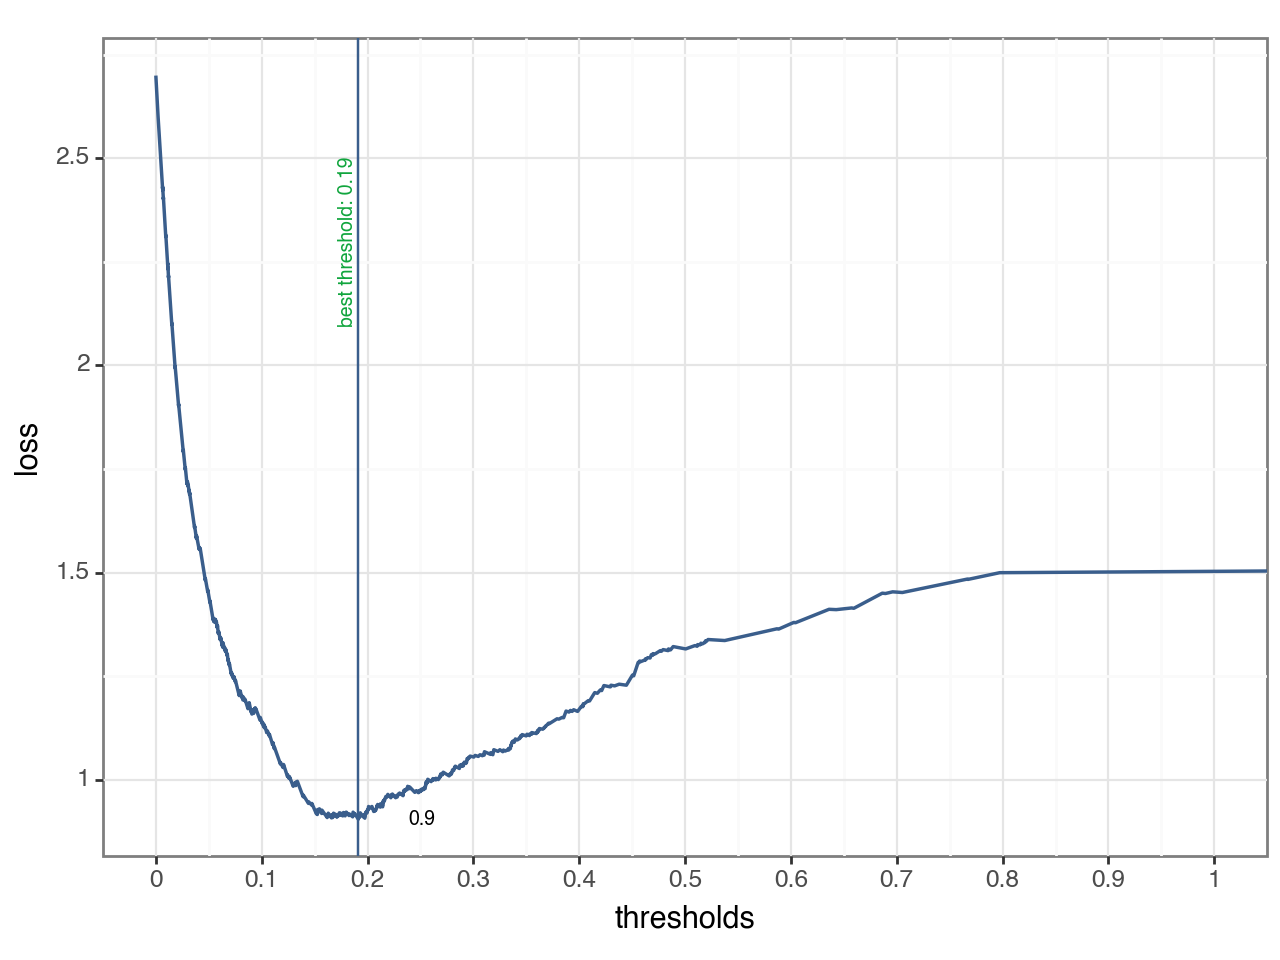

<Figure Size: (640 x 480)>

In [323]:
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

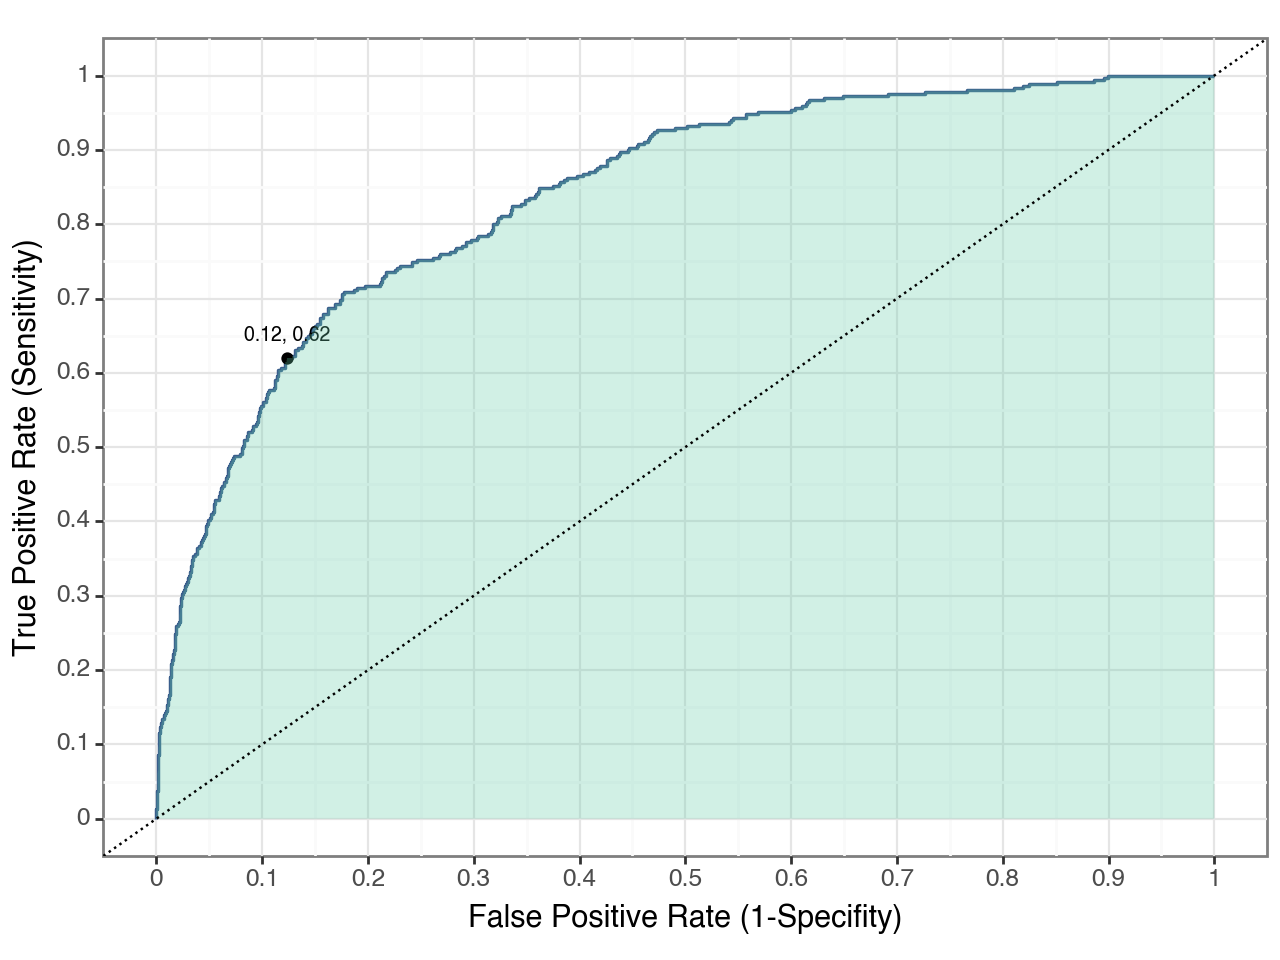

<Figure Size: (640 x 480)>

In [324]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

Take model to holdout and estimate RMSE, AUC and expected loss 

In [325]:
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[
    :, 1
]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)


0.207

ROC AUC  on holdout

In [326]:
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)


0.857

 Get expected loss on holdout

In [327]:
holdout_treshold = np.where(
    rf_predicted_probabilities_holdout < best_thresholds_cv["RF"], 0, 1
)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1]).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)
round(expected_loss_holdout, 3)


0.61

Compared to logit and lass models, random forest gives a bette expected loss on holdout data.

#### 2.9 Comparison of all models

In [328]:
summary["CV treshold"] = best_thresholds_cv
summary["CV expected Loss"] = expected_loss_cv

In [329]:
summary

,Number of Coefficients,CV RMSE,CV AUC,CV treshold,CV expected Loss
M1,12.0,0.285882,0.735093,0.156411,1.150369
M2,12.0,0.281584,0.772332,0.182375,1.107251
M3,29.0,0.285991,0.752445,0.166756,1.176464
M4,73.0,0.279311,0.799807,0.150728,1.060730
M5,154.0,0.278616,0.798916,0.149452,1.055867
LASSO,81.0,0.276076,0.806215,0.177636,1.043062
RF,n.a.,0.266482,0.835564,0.187648,0.930892


#### 2.10 Final Choice of Model

In the previous summary table, comparison of the cross validated expected losses, RMSE and AUC values on the train data show Random Forest as the best model.

In [330]:
# Calculate predictions using the optimal threshold
threshold_optimal = best_thresholds_cv["RF"]
predictions_holdout = np.where(rf_predicted_probabilities_holdout < threshold_optimal, 0, 1)

# Generate confusion matrix
cm_holdout = confusion_matrix(y_holdout, predictions_holdout)

# Convert to DataFrame for better visualization
cm_holdout_df = pd.DataFrame(cm_holdout, index=['Actual No Default', 'Actual Default'], 
                             columns=['Predicted No Default', 'Predicted Default'])

# Print confusion matrix
print("Confusion Matrix for Holdout Data (Random Forest Model):")
cm_holdout_df

Confusion Matrix for Holdout Data (Random Forest Model):


,Predicted No Default,Predicted Default
Actual No Default,885,96
Actual Default,23,33


In [331]:
from sklearn.metrics import accuracy_score

# Calculate Brier Score
brier_score_rf = mean_squared_error(y_holdout, rf_predicted_probabilities_holdout)

# Calculate ROC Curve and AUC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_holdout, rf_predicted_probabilities_holdout)
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)

# Calculate Accuracy, Sensitivity, and Specificity for optimal threshold
threshold_optimal = best_thresholds_cv["RF"]
predictions_holdout = np.where(rf_predicted_probabilities_holdout < threshold_optimal, 0, 1)
accuracy_holdout = accuracy_score(y_holdout, predictions_holdout)
tn, fp, fn, tp = confusion_matrix(y_holdout, predictions_holdout).ravel()
sensitivity_holdout = tp / (tp + fn)
specificity_holdout = tn / (tn + fp)

# Calculate Expected Loss for optimal threshold
expected_loss_holdout_optimal = (fp * 3 + fn * 15) / len(y_holdout)

# Descriptive Statistics for holdout sample
num_firms_holdout = len(data_holdout)
num_defaulted_holdout = sum(data_holdout['default'] == 1)
num_alive_holdout = num_firms_holdout - num_defaulted_holdout
num_defaulted_predicted = 33
num_alive_predicted = 885
num_alive_holdout = num_firms_holdout - num_defaulted_holdout
mean_sales_holdout = data_holdout['sales_mil'].mean()
min_sales_holdout = data_holdout['sales_mil'].min()
max_sales_holdout = data_holdout['sales_mil'].max()

# Store results in a DataFrame
results_holdout_rf = pd.DataFrame({
    'Metric': ['Brier Score', 'AUC', 'Accuracy', 'Sensitivity', 'Specificity', 'Expected Loss (Optimal Threshold)', 'Optimal Threshold'],
    'Value': [brier_score_rf, auc_rf, accuracy_holdout, sensitivity_holdout, specificity_holdout, expected_loss_holdout_optimal, threshold_optimal]
})

# Store descriptive statistics in a DataFrame
descriptive_stats_holdout = pd.DataFrame({
    'Metric': ['Number of Firms', 'Number of Defaulted Firms (Actual)', 'Number of Defaulted Firms (Predicted)', 
               'Number of Firms Stayed Alive (Actual)', 'Number of Firms Stayed Alive (Predicted)','Mean Sales (million EUR)', 
               'Minimum Sales (million EUR)', 'Maximum Sales (million EUR)'],
    'Value': [num_firms_holdout, num_defaulted_holdout, num_defaulted_predicted, num_alive_holdout, num_alive_predicted,
              mean_sales_holdout, min_sales_holdout, max_sales_holdout]
})

# Combine DataFrames
combined_df = pd.concat([results_holdout_rf, descriptive_stats_holdout]).reset_index(drop=True)

# Print Results
print("Random Forest Model Performance on Holdout Dataset:")
print("--------------------------------------------------")
combined_df

Random Forest Model Performance on Holdout Dataset:
--------------------------------------------------


,Metric,Value
0,Brier Score,0.042922
1,AUC,0.857288
2,Accuracy,0.885246
3,Sensitivity,0.589286
4,Specificity,0.902141
5,Expected Loss (Optimal Threshold),0.610415
6,Optimal Threshold,0.187648
7,Number of Firms,1037.000000
8,Number of Defaulted Firms (Actual),56.000000
9,Number of Defaulted Firms (Predicted),33.000000


The summary table for our selected model shows that we predict 33 defaults out of 56 actual defaults, which is not a bad success rate

### 3. Conclusion

In this analysis, we explored the use of random forest for predicting defaulted firms in the 'Manufacture of computer, electronic and optical products' industry for the year 2015. Through the development and evaluation of decision trees and random forests, we identified optimal parameters and evaluated model performance using cross-validation. The selected Random Forest model demonstrated promising results in terms of RMSE, AUC, and expected loss. This predictive model can serve as a valuable tool for stakeholders in proactively managing financial risks and facilitating informed decision-making within the specified industry segment.